# This Code Was Last Modified on March 19

## This script will help us understand the architectures generated from the morph matrix and to evaluate them on specific FOM

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
import math

## Delta V Table: Reflects most up to date version as constructed by Andrew

In [2]:
deltaVDF = pd.read_csv('../Resources/Analysis Delta V Table V 1.0.csv')
deltaVDF = deltaVDF.loc[0:8,"Earth":"Lunar Surface Polar"]
deltaVDF

,Earth,LEO KSC,LEO Equitorial,L1,L2,Gateway,Lunar Orbit,Lunar Surface Equitorial,Lunar Surface Polar
0,0.000,9.400,13.640,13.17,12.83,13.310,13.440,15.330,14.626
1,9.400,0.000,4.240,3.77,3.43,3.910,4.040,5.930,5.226
2,13.640,4.240,0.000,3.77,3.43,3.910,4.040,5.930,5.226
3,13.170,0.770,0.770,0.00,0.14,0.140,0.640,2.520,999.000
4,12.830,0.330,0.330,0.14,0.00,0.000,0.650,2.520,999.000
5,13.310,3.910,3.910,0.14,0.00,0.000,0.670,3.196,2.540
6,13.440,1.310,1.310,0.64,0.65,0.670,0.000,1.870,4.396
7,15.330,5.910,5.910,2.52,2.53,3.196,1.870,0.000,2.526
8,14.626,5.266,5.266,999.00,999.00,2.540,4.396,2.526,0.000


## The Morph Matrix is the key aspect of this study. We build the tradespace utilizing the decision points determined in the Morph Matrix. Let's take a look at it now

In [3]:
morph_matrix = pd.read_excel("../Resources/Simplified_Morph_Matrix_V10.xlsx")
morph_matrix

,Decision,Option 1,Option 2,Option 3,Option 4,Option 5,Option 6,Option 7,Option 8
0,Launch From Earth to:,LEO KSC,LEO Equitorial,L1,L2,Lunar Orbit,Gateway,Lunar Surface Equitorial,Lunar Surface Polar
1,Earth Orbit Rendezvous,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN
2,Lunar Orbit Rendezvous,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN
3,L1,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN
4,L2,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN
5,Gateway,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN
6,Moon Surface Arrival,Direct from Earth,Direct from LEO,Arrival from L1,Arrival from LLO,Arrival from Gateway,Arrival from L2,NaN,NaN
7,Lunar Surface Location,Lunar Surface Equitorial,Lunar Surface Polar,NaN,NaN,NaN,NaN,NaN,NaN
8,ISRU Facility,None,Non-lunar Fuel Depot,Lunar ISRU Facility,NaN,NaN,NaN,NaN,NaN
9,Moon Surface Stay Duration,5,10,15,20,30,40,NaN,NaN


In [4]:
"""
Necessary to slice the arrays to remove any NAN's. 
I did it as a hardcode since there was not much data to remove so was easier
"""

earthLaunch = np.array(morph_matrix.loc[0,:])[1:]
EOR = np.array(morph_matrix.loc[1,:])[1:][0:2]
LOR = np.array(morph_matrix.loc[2,:])[1:][0:2]
L1_options = np.array(morph_matrix.loc[3,:])[1:3]
L2_options = np.array(morph_matrix.loc[4,:])[1:3]
gateway = np.array(morph_matrix.loc[5,:])[1:][0:2]


surfaceArrival = np.array(morph_matrix.loc[6,:])[1:][0:6]
location = np.array(morph_matrix.loc[7,:])[1:][0:2]

moonISRU = np.array(morph_matrix.loc[8,:])[1:][0:3]
durationOnSurface = np.array(morph_matrix.loc[9,:])[1:7]
surfaceMobility = np.array(morph_matrix.loc[10,:])[1:][0:6]
numCrew = np.array(morph_matrix.loc[11,:])[1:][0:5]

## This function will create an architecture. Each architecture will contain the information as described below

In [5]:
def create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList):
    arch ={
        "Earth Launch": lv,
        "EOR": eor,
        "LOR": lor,
        "Used L1": l_1,
        "Used L2": l_2,
        "Used Gateway": useGateway,
        "Moon Surface Arrival": surAriv,
        "Lunar Surface Location": loc,
        "ISRU Capability": isru,
        "Surface Duration": surfaceDuration,
        "Surface Rover": mobility,
        "Number of Crew": crew,
        "Total Delta V": deltaV,
        "Delta V Stages": deltaVList}
    return arch

In [6]:
###
""" 
Constraints: 
Notes: Could add in some more points from LEO techincally
if Gateway = No
    1. If Launch to LEO, then can go the following Routes: 
        1. Earth - LEO - Arrive from LEO
        2. Earth - LEO - L1/L2 - Arrive from L1/L2
        3. Earth - LEO - L1/L2 - LLO - Arrive from LLO
        4. Earth - LEO - LLO - Arrive from LLO 
    2. Launch to L1/L2
        1. Earth - L1/L2 - Arrival from L1/L2
        2. Earth - L1/L2 - LLO - Arrival from LLO
    3. Launch to LLO
        1. Earth - LLO - Arrival from LLO
    4. Launch to Surface
        1. Earth -  Lunar Surface

if Gateway = Yes
    1. Launch to LEO
        1. Earth - LEO - Gateway - Arrive from Gateway
        2. Earth - LEO - Gateway - LLO - Arrive from LLO
    2. Launch to L1/L2
        1. Dont do this since gateway is here, so just go to gateway
    3. Launch to LLO or Lunar Surface 
        1. Cant happen either because need to stop at gateway
    4. Launch to Gateway
        1. Earth - Gateway - Arrive from Gateway
        2. Earth - Gateway - LLO - Arrive from LLO

"""
####

' \nConstraints: \nNotes: Could add in some more points from LEO techincally\nif Gateway = No\n    1. If Launch to LEO, then can go the following Routes: \n        1. Earth - LEO - Arrive from LEO\n        2. Earth - LEO - L1/L2 - Arrive from L1/L2\n        3. Earth - LEO - L1/L2 - LLO - Arrive from LLO\n        4. Earth - LEO - LLO - Arrive from LLO \n    2. Launch to L1/L2\n        1. Earth - L1/L2 - Arrival from L1/L2\n        2. Earth - L1/L2 - LLO - Arrival from LLO\n    3. Launch to LLO\n        1. Earth - LLO - Arrival from LLO\n    4. Launch to Surface\n        1. Earth -  Lunar Surface\n\nif Gateway = Yes\n    1. Launch to LEO\n        1. Earth - LEO - Gateway - Arrive from Gateway\n        2. Earth - LEO - Gateway - LLO - Arrive from LLO\n    2. Launch to L1/L2\n        1. Dont do this since gateway is here, so just go to gateway\n    3. Launch to LLO or Lunar Surface \n        1. Cant happen either because need to stop at gateway\n    4. Launch to Gateway\n        1. Earth -

# Lets Begin the Full Factorial Architecture Generation Process!

In [6]:
t0 = time.time()
constrained_architectures = []
total_archs = 0
LEO_Launch = 0
L1_Launch = 0
L2_Launch = 0
direct_lunar_orbit = 0
direct_lunar_surface = 0
gatewayLaunch = 0

additional_delta_V_EOR = 0.2

for useGateway in gateway:
    for lv in earthLaunch:
        for eor in EOR:
            for lor in LOR:
                for l_1 in L1_options:
                    for l_2 in L1_options:
                        for surAriv in surfaceArrival:
                            for loc in location:
                                for isru in moonISRU:
                                    for surfaceDuration in durationOnSurface:
                                        for mobility in surfaceMobility:
                                            for crew in numCrew:

                                                total_archs += 1
                                                totalDeltaV = 0
                                                
                                                if useGateway == "No":
                                                
                                                    #LEO KSC - Lunar Surface
                                                    if lv == "LEO KSC":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor == "No":
                                                                if surAriv in ["Direct from LEO"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO KSC'] + deltaVDF.loc[1, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO KSC'],deltaVDF.loc[1, loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                        
                                                    #LEO KSC - L1 - Surface
                                                    if lv == "LEO KSC":
                                                        if l_1 == "Yes" and l_2 == "No":
                                                            if lor == "No":
                                                                if surAriv in ["Arrival from L1"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO KSC'] + deltaVDF.loc[1, 'L1'] + deltaVDF.loc[3, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO KSC'],deltaVDF.loc[1, 'L1'],deltaVDF.loc[3, loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO KSC - L1 - LL0 -Surface                
                                                    if lv == "LEO KSC":
                                                         if l_1 == "Yes" and l_2 == "No":
                                                            if lor == "Yes":
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO KSC'] + deltaVDF.loc[1, 'L1'] + deltaVDF.loc[3, "Lunar Orbit"] + deltaVDF.loc[6, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO KSC'],deltaVDF.loc[1, 'L1'],deltaVDF.loc[3, "Lunar Orbit"],deltaVDF.loc[6, loc] ]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO KSC - L2 - Surface
                                                    if lv == "LEO KSC":
                                                        if l_1 == "No" and l_2 == "Yes":
                                                            if lor == "No":
                                                                if surAriv in ["Arrival from L1"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO KSC'] + deltaVDF.loc[1, 'L2'] + deltaVDF.loc[4, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO KSC'],deltaVDF.loc[1, 'L1'],deltaVDF.loc[4, loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO KSC - L2 - LL0 -Surface                
                                                    if lv == "LEO KSC":
                                                         if l_1 == "No" and l_2 == "Yes":
                                                            if lor == "Yes":
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO KSC'] + deltaVDF.loc[1, 'L2'] + deltaVDF.loc[4, "Lunar Orbit"] + deltaVDF.loc[6, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO KSC'],deltaVDF.loc[1, 'L1'],deltaVDF.loc[4, "Lunar Orbit"],deltaVDF.loc[6, loc] ]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)

                                                    #LEO KSC - LLO - Surface
                                                    if lv == "LEO KSC":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor in ["YES"]:
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,"LEO KSC"] + deltaVDF.loc[1,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,"LEO KSC"],deltaVDF.loc[1,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    
                                                    
                                                    #LEO Equ. - Lunar Surface
                                                    if lv == "LEO Equitorial":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor == "No":
                                                                if surAriv in ["Direct from LEO"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO Equitorial'] + deltaVDF.loc[2, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO Equitorial'],deltaVDF.loc[2, loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                        
                                                    #LEO Eq - L1 - Surface
                                                    if lv == "LEO Equitorial":
                                                        if l_1 == "Yes" and l_2 == "No":
                                                            if lor == "No":
                                                                if surAriv in ["Arrival from L1"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO Equitorial'] + deltaVDF.loc[2, 'L1'] + deltaVDF.loc[3, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO Equitorial'],deltaVDF.loc[2, 'L1'],deltaVDF.loc[3, loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO Eq - L1 - LL0 -Surface                
                                                    if lv == "LEO Equitorial":
                                                         if l_1 == "Yes" and l_2 == "No":
                                                            if lor == "Yes":
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO Equitorial'] + deltaVDF.loc[2, 'L1'] + deltaVDF.loc[3, "Lunar Orbit"] + deltaVDF.loc[6, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO Equitorial'],deltaVDF.loc[2, 'L1'],deltaVDF.loc[3, "Lunar Orbit"],deltaVDF.loc[6, loc] ]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO EQ - L2 - Surface
                                                    if lv == "LEO Equitorial":
                                                        if l_1 == "No" and l_2 == "Yes":
                                                            if lor == "No":
                                                                if surAriv in ["Arrival from L1"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO Equitorial'] + deltaVDF.loc[2, 'L2'] + deltaVDF.loc[4, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO Equitorial'],deltaVDF.loc[2, 'L1'],deltaVDF.loc[4, loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO Eq - L2 - LL0 -Surface                
                                                    if lv == "LEO Equitorial":
                                                         if l_1 == "No" and l_2 == "Yes":
                                                            if lor == "Yes":
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,'LEO Equitorial'] + deltaVDF.loc[2, 'L2'] + deltaVDF.loc[4, "Lunar Orbit"] + deltaVDF.loc[6, loc] 
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,'LEO Equitorial'],deltaVDF.loc[2, 'L1'],deltaVDF.loc[4, "Lunar Orbit"],deltaVDF.loc[6, loc] ]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)

                                                    #LEO Eq - LLO - Surface
                                                    if lv == "LEO Equitorial":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor in ["YES"]:
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,"LEO Equitorial"] + deltaVDF.loc[2,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,"LEO Equitorial"],deltaVDF.loc[2,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)

                                                    #L1 - Lunar Surface
                                                    if lv == "L1":
                                                        if eor == "No":
                                                            if l_1 == "Yes" and l_2 == "No":
                                                                if lor in ["No"]:
                                                                    if surAriv in ["Arrival from L1"]:
                                                                        deltaV = deltaVDF.loc[0,"L1"] + deltaVDF.loc[3,loc]
                                                                        deltaVList = [deltaVDF.loc[0,"L1"],deltaVDF.loc[3,loc]]
                                                                        L1_Launch += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)

                                                    #L1 - LLO - Lunar Surface
                                                    if lv == "L1":
                                                        if eor == "No":
                                                            if l_1 == "Yes" and l_2 == "No":
                                                                if lor in ["Yes"]:
                                                                    if surAriv in ["Arrival from LLO"]:
                                                                        deltaV = deltaVDF.loc[0,"L1"] + deltaVDF.loc[3,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                        deltaVList = [deltaVDF.loc[0,"L1"],deltaVDF.loc[3,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                        L1_Launch += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)
                                                    #L2 - Lunar Surface
                                                    if lv == "L2":
                                                        if eor == "No":
                                                            if l_1 == "No" and l_2 == "Yes":
                                                                if lor in ["No"]:
                                                                    if surAriv in ["Arrival from L2"]:
                                                                        deltaV = deltaVDF.loc[0,"L2"] + deltaVDF.loc[4,loc]
                                                                        deltaVList = [deltaVDF.loc[0,"L2"],deltaVDF.loc[4,loc]]
                                                                        L1_Launch += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)

                                                    #L2 - LLO - Lunar Surface
                                                    if lv == "L2":
                                                        if eor == "No":
                                                            if l_1 == "No" and l_2 == "Yes":
                                                                if lor in ["Yes"]:
                                                                    if surAriv in ["Arrival from LLO"]:
                                                                        deltaV = deltaVDF.loc[0,"L2"] + deltaVDF.loc[4,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                        deltaVList = [deltaVDF.loc[0,"L2"],deltaVDF.loc[4,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                        L1_Launch += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)
                                                    #LLO - Lunar Surface
                                                    if lv == "Lunar Orbit":
                                                        if eor == "No":
                                                            if l_1 == "No" and l_2 == "No":
                                                                if lor == "Yes":
                                                                    if surAriv in ["Arrival from LLO"]:
                                                                        deltaV = deltaVDF.loc[0,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                        deltaVList = [deltaVDF.loc[0,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                        direct_lunar_orbit += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)
                                                    #Lunar Surface
                                                    if lv in ["Lunar Surface Equitorial", "Lunar Surface Polar"]:
                                                        if eor == "No":
                                                            if l_1 == "No" and l_2 == "No":
                                                                if lor in ["No"]:
                                                                    if surAriv in ["Direct from Earth"]:
                                                                        deltaV = deltaVDF.loc[0,loc]
                                                                        deltaVList = [deltaVDF.loc[0,loc]]
                                                                        direct_lunar_surface += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)


                                        ##Gateway
                                                else:
                                                    #LEO KSC: LEO KSC - Gateway - Surface
                                                    if lv == "LEO KSC":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor == "No":
                                                                if surAriv in ["Arrival from Gateway"]:
                                                                    deltaV = deltaVDF.loc[0,"LEO KSC"] + deltaVDF.loc[1,"Gateway"] + deltaVDF.loc[5,loc]
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList =[deltaVDF.loc[0,"LEO KSC"],deltaVDF.loc[1,"Gateway"],deltaVDF.loc[5,loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO 1: LEO KSC - Gateway - LLO - Surface
                                                    if lv == "LEO KSC":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor == "Yes":
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,"LEO KSC"] + deltaVDF.loc[1,"Gateway"] + deltaVDF.loc[5,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,"LEO KSC"],deltaVDF.loc[1,"Gateway"],deltaVDF.loc[5,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                                    
                                                    #LEO Eq: LEO Eq - Gateway - Surface
                                                    if lv == "LEO Equitorial":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor == "No":
                                                                if surAriv in ["Arrival from Gateway"]:
                                                                    deltaV = deltaVDF.loc[0,"LEO Equitorial"] + deltaVDF.loc[2,"Gateway"] + deltaVDF.loc[5,loc]
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList =[deltaVDF.loc[0,"LEO Equitorial"],deltaVDF.loc[2,"Gateway"],deltaVDF.loc[5,loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)
                                                    #LEO 1: LEO Eq - Gateway - LLO - Surface
                                                    if lv == "LEO Equitorial":
                                                        if l_1 == "No" and l_2 == "No":
                                                            if lor == "Yes":
                                                                if surAriv in ["Arrival from LLO"]:
                                                                    deltaV = deltaVDF.loc[0,"LEO Equitorial"] + deltaVDF.loc[2,"Gateway"] + deltaVDF.loc[5,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                    if eor == "Yes":
                                                                        deltaV += additional_delta_V_EOR
                                                                    deltaVList = [deltaVDF.loc[0,"LEO Equitorial"],deltaVDF.loc[2,"Gateway"],deltaVDF.loc[5,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                    LEO_Launch += 1
                                                                    arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                    constrained_architectures.append(arch)

                                                    #GatewayDirectLaunch
                                                    if lv == "Gateway":
                                                        if eor == "No":
                                                            if l_1 == "No" and l_2 == "No":
                                                                if lor == "No":
                                                                    if surAriv in ["Arrival from Gateway"]:
                                                                        deltaV = deltaVDF.loc[0,"Gateway"] + deltaVDF.loc[5,loc]
                                                                        deltaVList = [deltaVDF.loc[0,"Gateway"], deltaVDF.loc[5,loc]]
                                                                        gatewayLaunch += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)
                                                    #Gateway to LLO to surface
                                                    if lv == "Gateway":
                                                        if eor == "No":
                                                            if l_1 == "No" and l_2 == "No":
                                                                if lor == "Yes":
                                                                    if surAriv in ["Arrival from LLO"]:
                                                                        deltaV =  deltaVDF.loc[0,"Gateway"] + deltaVDF.loc[5,"Lunar Orbit"] + deltaVDF.loc[6,loc]
                                                                        deltaVList = [deltaVDF.loc[0,"Gateway"],deltaVDF.loc[5,"Lunar Orbit"],deltaVDF.loc[6,loc]]
                                                                        gatewayLaunch += 1
                                                                        arch = create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)
                                                                        constrained_architectures.append(arch)




                                
t1 = time.time()
print("Total Runtime: %.2f seconds" %(t1-t0))
print("Total number of constrained architectures: {}".format(len(constrained_architectures)))
print("Total number of architectures: {}".format(total_archs))

Total Runtime: 6.54 seconds
Total number of constrained architectures: 39960
Total number of architectures: 1658880


# Now that we have all the important enumerations, lets put it into a datafame and begin our operations

In [7]:
##create a dataframe fo the archs
df = pd.DataFrame(constrained_architectures)
df.head()

,Delta V Stages,EOR,Earth Launch,ISRU Capability,LOR,Lunar Surface Location,Moon Surface Arrival,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,Used L1,Used L2
0,"[9.4, 3.91, 0.67, 1.87]",Yes,LEO KSC,None,Yes,Lunar Surface Equitorial,Arrival from LLO,1,5,None,16.05,Yes,No,No
1,"[9.4, 3.91, 0.67, 1.87]",Yes,LEO KSC,None,Yes,Lunar Surface Equitorial,Arrival from LLO,2,5,None,16.05,Yes,No,No
2,"[9.4, 3.91, 0.67, 1.87]",Yes,LEO KSC,None,Yes,Lunar Surface Equitorial,Arrival from LLO,3,5,None,16.05,Yes,No,No
3,"[9.4, 3.91, 0.67, 1.87]",Yes,LEO KSC,None,Yes,Lunar Surface Equitorial,Arrival from LLO,4,5,None,16.05,Yes,No,No
4,"[9.4, 3.91, 0.67, 1.87]",Yes,LEO KSC,None,Yes,Lunar Surface Equitorial,Arrival from LLO,5,5,None,16.05,Yes,No,No


## First Step: Remove the architectures that have poor energy from a delta V standpoint

## Also want to remove architectures that go direct from earth to the moon - not a really valid option

In [8]:
A = df[df['Total Delta V'] <= 100] 
B = A[A['Earth Launch'] != "Lunar Surface Equitorial"]
C = B[B['Earth Launch'] != "Lunar Surface Polar"]


df_1 = C
##Utilized a heuristic saying poor energy is = 999 km/s so if we filter out less than 100 we will get the good archs

In [9]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32400 entries, 0 to 37799
Data columns (total 14 columns):
Delta V Stages            32400 non-null object
EOR                       32400 non-null object
Earth Launch              32400 non-null object
ISRU Capability           32400 non-null object
LOR                       32400 non-null object
Lunar Surface Location    32400 non-null object
Moon Surface Arrival      32400 non-null object
Number of Crew            32400 non-null int64
Surface Duration          32400 non-null int64
Surface Rover             32400 non-null object
Total Delta V             32400 non-null float64
Used Gateway              32400 non-null object
Used L1                   32400 non-null object
Used L2                   32400 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 3.7+ MB


## From the above, there are 32,400 architectures that are realistic given the trade space exploration and energy requirements listed above

# Lets Bring in the baseline architectures
    - Apollo 
    - Constellation
    - NASA DRM

In [10]:
def apollo_17_arch():
    useGateway = "No"
    lv = "LEO KSC"
    eor = "No"
    lor = "Yes"
    l_1 = "No"
    l_2 = "No"
    surAriv = "Arrival from LLO"
    loc = "Lunar Surface Equitorial"
    isru = "None"
    surfaceDuration = 5
    mobility = "Apollo"
    crew = 3
    deltaV = deltaVDF.loc[0,"LEO KSC"] + deltaVDF.loc[1,"Lunar Orbit"] + deltaVDF.loc[6,"Lunar Surface Equitorial"]
    deltaVList = [deltaVDF.loc[0,"LEO KSC"],deltaVDF.loc[1,"Lunar Orbit"],deltaVDF.loc[6,"Lunar Surface Equitorial"]]
    return create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)

def constellation():
    useGateway = "No"
    lv = "LEO KSC"
    eor = "No"
    lor = "Yes"
    l_1 = "No"
    l_2 = "No"
    surAriv = "Arrival from LLO"
    loc = "Lunar Surface Polar"
    isru = "None"
    surfaceDuration = 10
    mobility = "Upgraded Apollo"
    crew = 4
    deltaV = deltaVDF.loc[0,"LEO KSC"] + deltaVDF.loc[1,"Lunar Orbit"] + deltaVDF.loc[6,"Lunar Surface Polar"]
    deltaVList = [deltaVDF.loc[0,"LEO KSC"],deltaVDF.loc[1,"Lunar Orbit"],deltaVDF.loc[6,"Lunar Surface Polar"]]
    return create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)

def NASA_DRM():
    useGateway = "Yes"
    lv = "Gateway"
    eor = "No"
    lor = "No"
    l_1 = "No"
    l_2 = "No"
    surAriv = "Arrival from Gateway"
    loc = "Lunar Surface Polar"
    isru = "Lunar ISRU Facility"
    surfaceDuration = 10
    mobility = "Extended Apollo"
    crew = 4
    deltaV = deltaVDF.loc[0,"Gateway"] + deltaVDF.loc[5,"Lunar Surface Polar"]
    deltaVList = [deltaVDF.loc[0,"Gateway"], deltaVDF.loc[5,"Lunar Surface Polar"]]
    return create_arch(lv, eor,lor,l_1,l_2,useGateway,surAriv,loc,isru,surfaceDuration,mobility,crew, deltaV,deltaVList)


    
apollo_arch = apollo_17_arch()
constellation_arch = constellation()
nasa_drm_arch = NASA_DRM()
reference_df = pd.DataFrame([apollo_arch,
                             constellation_arch,
                             nasa_drm_arch
                            ]) #make sure you make it a list! 
reference_df.rename(index={0:'Apollo 17', 1: 'Constellation',2: "NASA DRM"
                           }, inplace=True)


In [11]:
reference_df

,Delta V Stages,EOR,Earth Launch,ISRU Capability,LOR,Lunar Surface Location,Moon Surface Arrival,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,Used L1,Used L2
Apollo 17,"[9.4, 4.04, 1.87]",No,LEO KSC,None,Yes,Lunar Surface Equitorial,Arrival from LLO,3,5,Apollo,15.310,No,No,No
Constellation,"[9.4, 4.04, 4.396]",No,LEO KSC,None,Yes,Lunar Surface Polar,Arrival from LLO,4,10,Upgraded Apollo,17.836,No,No,No
NASA DRM,"[13.31, 2.54]",No,Gateway,Lunar ISRU Facility,No,Lunar Surface Polar,Arrival from Gateway,4,10,Extended Apollo,15.850,Yes,No,No


## Lets Now get a better understanding of the trajectory taken to the lunar surface

In [12]:
def trajectory(row):
    launch_from_earth_to = row['Earth Launch']
    used_l1 = row["Used L1"]
    used_l2 = row['Used L2']
    used_gateway = row['Used Gateway']
    moon_arrival = row['Moon Surface Arrival']
    surface = row['Lunar Surface Location']
    lor = row['LOR']
    
    new_launch_from_earth_to = launch_from_earth_to
    if launch_from_earth_to == "Lunar Orbit":
        new_launch_from_earth_to = "LLO"

   
    new_list = ["Earth", new_launch_from_earth_to]
#     if launch_from_earth_to in ["Lunar Surface Equitorial", "Lunar Surface Polar"]:
#         return new_list
    if used_l1 == "Yes":
        new_list.append("L1")
    if used_l2 == 'Yes':
        new_list.append("L2")
    if used_gateway == "Yes" and launch_from_earth_to != "Gateway":
        new_list.append("Gateway")
    if lor == 'Yes' and launch_from_earth_to != "Lunar Orbit":
        new_list.append("LLO")
    
#     new_list.append(moon_arrival)
    new_list.append(surface)
    
        
    return new_list


df_1['Trajectory'] = df_1.apply(trajectory, axis = 1)
reference_df['Trajectory'] = reference_df.apply(trajectory,axis = 1)

/anaconda/envs/eric_env/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# df_1.head()
reference_df.head()

,Delta V Stages,EOR,Earth Launch,ISRU Capability,LOR,Lunar Surface Location,Moon Surface Arrival,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,Used L1,Used L2,Trajectory
Apollo 17,"[9.4, 4.04, 1.87]",No,LEO KSC,None,Yes,Lunar Surface Equitorial,Arrival from LLO,3,5,Apollo,15.310,No,No,No,"[Earth, LEO KSC, LLO, Lunar Surface Equitorial]"
Constellation,"[9.4, 4.04, 4.396]",No,LEO KSC,None,Yes,Lunar Surface Polar,Arrival from LLO,4,10,Upgraded Apollo,17.836,No,No,No,"[Earth, LEO KSC, LLO, Lunar Surface Polar]"
NASA DRM,"[13.31, 2.54]",No,Gateway,Lunar ISRU Facility,No,Lunar Surface Polar,Arrival from Gateway,4,10,Extended Apollo,15.850,Yes,No,No,"[Earth, Gateway, Lunar Surface Polar]"


# We will now utilize a new data frame that drops a lot of the un-necessary information

In [14]:
df_2 = df_1.drop(labels = ['Earth Launch','Moon Surface Arrival', 'Used L1', 'Used L2'],axis = 1)
reference_df = reference_df.drop(labels = ['Earth Launch','Moon Surface Arrival', 'Used L1', 'Used L2'],axis = 1)
#Lets also examine the number of critical mission events
df_2['# of Critical Mission Burns'] = df_2['Delta V Stages'].apply(lambda x: len(x))
reference_df['# of Critical Mission Burns'] = reference_df['Delta V Stages'].apply(lambda x: len(x))
df_2.head()

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,Trajectory,# of Critical Mission Burns
0,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,1,5,None,16.05,Yes,"[Earth, LEO KSC, Gateway, LLO, Lunar Surface E...",4
1,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,2,5,None,16.05,Yes,"[Earth, LEO KSC, Gateway, LLO, Lunar Surface E...",4
2,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,3,5,None,16.05,Yes,"[Earth, LEO KSC, Gateway, LLO, Lunar Surface E...",4
3,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,4,5,None,16.05,Yes,"[Earth, LEO KSC, Gateway, LLO, Lunar Surface E...",4
4,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,5,5,None,16.05,Yes,"[Earth, LEO KSC, Gateway, LLO, Lunar Surface E...",4


In [15]:
reference_df

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,Trajectory,# of Critical Mission Burns
Apollo 17,"[9.4, 4.04, 1.87]",No,None,Yes,Lunar Surface Equitorial,3,5,Apollo,15.310,No,"[Earth, LEO KSC, LLO, Lunar Surface Equitorial]",3
Constellation,"[9.4, 4.04, 4.396]",No,None,Yes,Lunar Surface Polar,4,10,Upgraded Apollo,17.836,No,"[Earth, LEO KSC, LLO, Lunar Surface Polar]",3
NASA DRM,"[13.31, 2.54]",No,Lunar ISRU Facility,No,Lunar Surface Polar,4,10,Extended Apollo,15.850,Yes,"[Earth, Gateway, Lunar Surface Polar]",2


# We now want to start breaking down the Mass Estimate.


## Mass is considered a function of the following:

1. Number of Crew
2. Number of days spent on the surface
3. The size of your rover - for exploration purposes [larger the rover, more range you will have]
4. ISRU Infrastructure Build-up.
    -Assume we want to build up the infrastrucutre regardless of size in same time
    -more output will require more infrastructure, to a point, and this should be shown in the output

### First lets examine crew days and consumables due to that

In [16]:
df_2['Total Crew Days'] = df_2.apply(lambda x: x['Number of Crew']*x['Surface Duration'], axis = 1)
reference_df['Total Crew Days'] = reference_df.apply(lambda x: x['Number of Crew']*x['Surface Duration'], axis = 1)

consumables_per_crew_day_kg = (0.62 #Solid Food needed per crewmember day
                               + 0.83 #oxygen needer per crew member day
                               + 0.3 #Oxygen tank mass
                               + 4.16 #Water consumed per crew member day
                               + 0.83 #Water Tanks
                               + 20 #roughly average for water needs for hygenie and food prep
                               + 4.98 #ammount of human output that must be dealt with
                               + 1.75 #LiOH tank mass and gas mass
                              )*1.25 #25% margin added
df_2['Consumables Needed'] = df_2['Total Crew Days'].apply(lambda x: x*consumables_per_crew_day_kg) 
reference_df['Consumables Needed'] = reference_df['Total Crew Days'].apply(lambda x: x*consumables_per_crew_day_kg) 
#Source: Jones, H. W. (2019). Much Lower Launch Costs Make Resupply Cheaper Than Recycling for Space Life Support, (July 2017).

## Lets take a look at how the rover impacts the architectures.

### From Julia's work, we have a range and mass for each rover delivered to the lunar surface
### see here for more: https://docs.google.com/spreadsheets/d/1QrAh0bdFhVNx1RU2nuRNO0dLfND0yvuKBugBn1NHlvM/edit#gid=0

In [17]:
rovers = {
    #List goes in following: Mass of Rover, Number of People, Payload Capacity, Max Range, Pressurized
    "None": [0,0,0,2,"No"], 
    "Apollo": [210,2,490,7.6,"No"],
    "SEV": [2994,2,998,201,"Yes"],
    "Upgraded Apollo": [157.7,2,490,7.6,"No"],
    "Extended Apollo": [189,4,490,7.6,"No"],
    "Extended SEV": [3900,4,1100,201,"Yes"]
}

df_2['Exploration Range (km)'] = df_2['Surface Rover'].apply(lambda x: rovers[x][3])
df_2['Rover Mass'] = df_2['Surface Rover'].apply(lambda x: rovers[x][0])
df_2['Rover Payload Capacity'] = df_2['Surface Rover'].apply(lambda x: rovers[x][2])
df_2['Total Exploration Capability'] = df_2.apply(lambda x: x['Rover Payload Capacity']*x['Surface Duration'], axis = 1)

reference_df['Exploration Range (km)'] = reference_df['Surface Rover'].apply(lambda x: rovers[x][3])
reference_df['Rover Mass'] = reference_df['Surface Rover'].apply(lambda x: rovers[x][0])
reference_df['Rover Payload Capacity'] = reference_df['Surface Rover'].apply(lambda x: rovers[x][2])
reference_df['Total Exploration Capability'] = reference_df.apply(lambda x: x['Rover Payload Capacity']*x['Surface Duration'], axis = 1)

reference_df

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,Trajectory,# of Critical Mission Burns,Total Crew Days,Consumables Needed,Exploration Range (km),Rover Mass,Rover Payload Capacity,Total Exploration Capability
Apollo 17,"[9.4, 4.04, 1.87]",No,None,Yes,Lunar Surface Equitorial,3,5,Apollo,15.310,No,"[Earth, LEO KSC, LLO, Lunar Surface Equitorial]",3,15,627.5625,7.6,210.0,490,2450
Constellation,"[9.4, 4.04, 4.396]",No,None,Yes,Lunar Surface Polar,4,10,Upgraded Apollo,17.836,No,"[Earth, LEO KSC, LLO, Lunar Surface Polar]",3,40,1673.5000,7.6,157.7,490,4900
NASA DRM,"[13.31, 2.54]",No,Lunar ISRU Facility,No,Lunar Surface Polar,4,10,Extended Apollo,15.850,Yes,"[Earth, Gateway, Lunar Surface Polar]",2,40,1673.5000,7.6,189.0,490,4900


## ISRU Stuff

### Values come from the great work conducted by Dylan
https://docs.google.com/document/d/1UcWaBQNtsd_8cIQBZEE-Ba0FWRL0tG3eJkCHUBBtXxI/edit

In [18]:
mass_to_surface_for_ISRU = {
    "None": 0,
    "Non-lunar Fuel Depot": 1955,
    "Lunar ISRU Facility": 2644,
}

df_2["Surface Mass due to ISRU"] = df_2['ISRU Capability'].apply(lambda x: mass_to_surface_for_ISRU[x])
df_2['Refuel Capability on Surface'] = df_2['ISRU Capability'].apply(lambda x: True if x == "Lunar ISRU Facility" else False)

reference_df["Surface Mass due to ISRU"] = reference_df['ISRU Capability'].apply(lambda x: mass_to_surface_for_ISRU[x])
reference_df['Refuel Capability on Surface'] = reference_df['ISRU Capability'].apply(lambda x: True if x == "Lunar ISRU Facility" else False)



In [19]:
df_2.tail()

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,Trajectory,# of Critical Mission Burns,Total Crew Days,Consumables Needed,Exploration Range (km),Rover Mass,Rover Payload Capacity,Total Exploration Capability,Surface Mass due to ISRU,Refuel Capability on Surface
37795,"[13.44, 4.396]",No,Lunar ISRU Facility,Yes,Lunar Surface Polar,1,40,Extended SEV,17.836,No,"[Earth, LLO, Lunar Surface Polar]",2,40,1673.5,201.0,3900.0,1100,44000,2644,True
37796,"[13.44, 4.396]",No,Lunar ISRU Facility,Yes,Lunar Surface Polar,2,40,Extended SEV,17.836,No,"[Earth, LLO, Lunar Surface Polar]",2,80,3347.0,201.0,3900.0,1100,44000,2644,True
37797,"[13.44, 4.396]",No,Lunar ISRU Facility,Yes,Lunar Surface Polar,3,40,Extended SEV,17.836,No,"[Earth, LLO, Lunar Surface Polar]",2,120,5020.5,201.0,3900.0,1100,44000,2644,True
37798,"[13.44, 4.396]",No,Lunar ISRU Facility,Yes,Lunar Surface Polar,4,40,Extended SEV,17.836,No,"[Earth, LLO, Lunar Surface Polar]",2,160,6694.0,201.0,3900.0,1100,44000,2644,True
37799,"[13.44, 4.396]",No,Lunar ISRU Facility,Yes,Lunar Surface Polar,5,40,Extended SEV,17.836,No,"[Earth, LLO, Lunar Surface Polar]",2,200,8367.5,201.0,3900.0,1100,44000,2644,True


# Now that we have all the information to define the mass on surface, lets calculate it and assign it to each arch.

### Idea: Create an other variable to add some mass. Any additional values/inputs we feel should be incorporated from a mass lens


In [20]:
###Still need to update based on ISRU
def mass_on_surface(row):
    mass_on_surface = (row['Consumables Needed']
                       + row['Rover Mass']
                       + row['Surface Mass due to ISRU']
#                        + row['Other Mass']
                      )
    return mass_on_surface

reference_df['Mass on Surface'] = reference_df.apply(mass_on_surface, axis = 1)
df_2['Mass on Surface'] = df_2.apply(mass_on_surface, axis = 1)
df_2.head()

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,...,# of Critical Mission Burns,Total Crew Days,Consumables Needed,Exploration Range (km),Rover Mass,Rover Payload Capacity,Total Exploration Capability,Surface Mass due to ISRU,Refuel Capability on Surface,Mass on Surface
0,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,1,5,None,16.05,Yes,...,4,5,209.1875,2.0,0.0,0,0,0,False,209.1875
1,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,2,5,None,16.05,Yes,...,4,10,418.3750,2.0,0.0,0,0,0,False,418.3750
2,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,3,5,None,16.05,Yes,...,4,15,627.5625,2.0,0.0,0,0,0,False,627.5625
3,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,4,5,None,16.05,Yes,...,4,20,836.7500,2.0,0.0,0,0,0,False,836.7500
4,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,5,5,None,16.05,Yes,...,4,25,1045.9375,2.0,0.0,0,0,0,False,1045.9375


# Now that we have the mass on the surface, we can utilize the rocket equation.
## The rocket equation will tell us how much propellant each stage of the trip will take, if we assume a different propulsive vehicle for each stage. This is a large assumption, but will give a first order estimate of the mass launched to the first portion of the trip which is a key FOM

In [21]:
def rocket_equation(row,isp):
    trajectory = row['Trajectory']
    delta_v_stages = row['Delta V Stages']
    final_mass_on_surface = row['Mass on Surface']
    stage_wet_mass = 0
    final_wet_mass = 0
    dry_mass = final_mass_on_surface
    for ele in delta_v_stages[::-1][0:-1]: #Note that i dont include the first stage here. So this is the mass after the rocket takes it to where it needs to go
        stage_wet_mass = dry_mass*(math.e**((ele*1000)/(9.81*isp)))
        dry_mass = stage_wet_mass
        final_wet_mass += stage_wet_mass
    return final_wet_mass/1000

def rocket_equation_from_earth(row):
    trajectory = row['Trajectory']
    required_delta_v = row['Delta V Stages'][0]
    mass_delivered_LOX_LH2 = row['Mass Delivered to Staging Point 1 with LOX/LH2']
    mass_delivered_LOX_CH4 = row['Mass Delivered to Staging Point 1 with LOX/CH4']
    propellant_needs_LOX_LH2 = mass_delivered_LOX_LH2*(math.e**((required_delta_v*1000)/(9.81*450))) - mass_delivered_LOX_LH2
    propellant_needs_LOX_CH4 = mass_delivered_LOX_CH4*(math.e**((required_delta_v*1000)/(9.81*380))) - mass_delivered_LOX_CH4
    return (propellant_needs_LOX_LH2,propellant_needs_LOX_CH4)
    
  
df_2['Mass Delivered to Staging Point 1 with LOX/LH2'] = df_2.apply(lambda x: rocket_equation(x,isp=450), axis = 1)
df_2['Mass Delivered to Staging Point 1 with LOX/CH4'] = df_2.apply(lambda x: rocket_equation(x,isp=380), axis = 1)
#For explanation purposes, it will be helpful to know which stop is first on the trip
df_2["First Stop From Earth"] = df_2['Trajectory'].apply(lambda x: x[1])


reference_df['Mass Delivered to Staging Point 1 with LOX/LH2'] = reference_df.apply(lambda x: rocket_equation(x,isp=450), axis = 1)
reference_df['Mass Delivered to Staging Point 1 with LOX/CH4'] = reference_df.apply(lambda x: rocket_equation(x,isp=380), axis = 1)
reference_df["First Stop From Earth"] = reference_df['Trajectory'].apply(lambda x: x[1])

df_2['Propellant Needs to Staging Point 1: LOX/LH2 Mass'] = df_2.apply(lambda x: rocket_equation_from_earth(x)[0],axis = 1)
df_2['Propellant Needs to Staging Point 1: LOX/CH4 Mass'] = df_2.apply(lambda x: rocket_equation_from_earth(x)[1],axis = 1)

reference_df['Propellant Needs to Staging Point 1: LOX/LH2 Mass'] = reference_df.apply(lambda x: rocket_equation_from_earth(x)[0],axis = 1)
reference_df['Propellant Needs to Staging Point 1: LOX/CH4 Mass'] = reference_df.apply(lambda x: rocket_equation_from_earth(x)[1],axis = 1)



In [22]:
reference_df.head()

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,...,Rover Payload Capacity,Total Exploration Capability,Surface Mass due to ISRU,Refuel Capability on Surface,Mass on Surface,Mass Delivered to Staging Point 1 with LOX/LH2,Mass Delivered to Staging Point 1 with LOX/CH4,First Stop From Earth,Propellant Needs to Staging Point 1: LOX/LH2 Mass,Propellant Needs to Staging Point 1: LOX/CH4 Mass
Apollo 17,"[9.4, 4.04, 1.87]",No,None,Yes,Lunar Surface Equitorial,3,5,Apollo,15.310,No,...,490,2450,0,False,837.5625,4.474096,5.471456,LEO KSC,33.150229,62.639578
Constellation,"[9.4, 4.04, 4.396]",No,None,Yes,Lunar Surface Polar,4,10,Upgraded Apollo,17.836,No,...,490,4900,0,False,1831.2000,17.335223,23.556153,LEO KSC,128.443066,269.680966
NASA DRM,"[13.31, 2.54]",No,Lunar ISRU Facility,No,Lunar Surface Polar,4,10,Extended Apollo,15.850,Yes,...,490,4900,2644,True,4506.5000,8.011655,8.907448,Gateway,155.349168,307.603662


# Now that we have the important information, lets begin to look at the FOMs
## We're going to start with the following five FOMs
### Exploration Capability
exploration range (km) * total crew days
### Relative Exploration Capability
Exploration Capability / Apollo 17 Exploration Capability
### Injected Mass into Low Earth Orbit (IMLEO)
Initial mass off all components including fuel in LEO
### Risk
The number of mission critical events that have to happen, right now we're just going to define this as the number of burns which need to be performed
### Commerical Merit
total cost / crew days on surface

### Let's start with cost

In [23]:
def cost_of_arch(row):
    injected_mass_LOX_LH2 = row['Propellant Needs to Staging Point 1: LOX/LH2 Mass']
    injected_mass_LOX_CH4 = row['Propellant Needs to Staging Point 1: LOX/CH4 Mass']

    cost = injected_mass_LOX_CH4 * 1000000
    #$10000/kg of fuel needed. The prop needs are in metric tons so its $1000000/MT 
    
    return cost

df_2['Cost'] = df_2.apply(cost_of_arch, axis = 1)
reference_df['Cost'] = reference_df.apply(cost_of_arch, axis = 1)


### Now we examine exploration Capability

In [24]:
reference_df['Exploration Capability (km*CrewDays)'] = reference_df.apply(lambda x: x['Exploration Range (km)'] * (x['Total Crew Days']**0.5), axis = 1)
df_2['Exploration Capability (km*CrewDays)'] = df_2.apply(lambda x: x['Exploration Range (km)'] *(x['Total Crew Days']**0.5), axis = 1)

### Now we examine IMLEO & Risk

In [25]:
df_2['IMLEO'] = df_2['Mass Delivered to Staging Point 1 with LOX/CH4']
reference_df['IMLEO'] = reference_df['Mass Delivered to Staging Point 1 with LOX/CH4']

df_2['Risk'] = df_2['# of Critical Mission Burns']
reference_df['Risk'] = reference_df['# of Critical Mission Burns']

### FInally let us look at Commercial Merit

In [26]:
df_2['Commercial Merit'] = df_2['Cost'] / (df_2['Number of Crew'] * df_2['Surface Duration'])
reference_df['Commercial Merit'] = reference_df['Cost'] / (reference_df['Number of Crew'] * reference_df['Surface Duration'])


### Important to Scale versus the reference architectures. In particular, lets examine how it scales to Apollo 17, the last mission on the lunar surface

In [27]:
df_2['Relative Exploration Capability to Apollo 17 '] = df_2.apply(lambda x: x['Exploration Capability (km*CrewDays)'] / reference_df['Exploration Capability (km*CrewDays)']['Apollo 17'], axis = 1)
df_2['Relative IMLEO to Apollo 17'] = df_2['Mass Delivered to Staging Point 1 with LOX/LH2'] / reference_df['Mass Delivered to Staging Point 1 with LOX/LH2']['Apollo 17']
df_2['Relative Risk to Apollo 17']= df_2['Risk'] / reference_df['# of Critical Mission Burns']['Apollo 17']
Apollo_17_Commercial_Merit = reference_df['Cost']['Apollo 17'] / (reference_df['Number of Crew']['Apollo 17'] * reference_df['Surface Duration']['Apollo 17'])
df_2['Relative Commercial Merit to Apollo 17'] = df_2['Commercial Merit'] / Apollo_17_Commercial_Merit
df_2['Relative Cost'] = df_2['Cost']/reference_df['Cost']['Apollo 17']


### Utitlizing this frame work we can think of a total score metric that attempts to bring together all of these FOM

#### Define Total score as the relative exploration capability of an arch. divided by the sum of relative IMLEO, Relative Risk and relative commercial merit.

#### High scores will have large exploration capability, low IMLEO, low risk, and low cost


In [28]:
df_2['Total Score'] = (df_2['Relative Exploration Capability to Apollo 17 '] / (df_2['Relative IMLEO to Apollo 17'] 
                         + df_2['Relative Risk to Apollo 17'] + df_2['Relative Cost']))
# df_2['Total Score'] = (df_2['Exploration Capability (km*CrewDays)'] / (df_2['IMLEO'] 
#                          + df_2['Risk'] + df_2['Cost']))


In [29]:
df_2.head()

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,...,Exploration Capability (km*CrewDays),IMLEO,Risk,Commercial Merit,Relative Exploration Capability to Apollo 17,Relative IMLEO to Apollo 17,Relative Risk to Apollo 17,Relative Commercial Merit to Apollo 17,Relative Cost,Total Score
0,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,1,5,None,16.05,Yes,...,4.472136,1.939173,4,4.440098e+06,0.151934,0.356085,1.333333,1.063249,0.354416,0.074338
1,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,2,5,None,16.05,Yes,...,6.324555,3.878346,4,4.440098e+06,0.214868,0.712170,1.333333,1.063249,0.708833,0.078011
2,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,3,5,None,16.05,Yes,...,7.745967,5.817520,4,4.440098e+06,0.263158,1.068254,1.333333,1.063249,1.063249,0.075951
3,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,4,5,None,16.05,Yes,...,8.944272,7.756693,4,4.440098e+06,0.303869,1.424339,1.333333,1.063249,1.417665,0.072777
4,"[9.4, 3.91, 0.67, 1.87]",Yes,None,Yes,Lunar Surface Equitorial,5,5,None,16.05,Yes,...,10.000000,9.695866,4,4.440098e+06,0.339735,1.780424,1.333333,1.063249,1.772082,0.069535


## Lets look at the variables we get to work with

In [30]:
df_2.columns

Index(['Delta V Stages', 'EOR', 'ISRU Capability', 'LOR',
       'Lunar Surface Location', 'Number of Crew', 'Surface Duration',
       'Surface Rover', 'Total Delta V', 'Used Gateway', 'Trajectory',
       '# of Critical Mission Burns', 'Total Crew Days', 'Consumables Needed',
       'Exploration Range (km)', 'Rover Mass', 'Rover Payload Capacity',
       'Total Exploration Capability', 'Surface Mass due to ISRU',
       'Refuel Capability on Surface', 'Mass on Surface',
       'Mass Delivered to Staging Point 1 with LOX/LH2',
       'Mass Delivered to Staging Point 1 with LOX/CH4',
       'First Stop From Earth',
       'Propellant Needs to Staging Point 1: LOX/LH2 Mass',
       'Propellant Needs to Staging Point 1: LOX/CH4 Mass', 'Cost',
       'Exploration Capability (km*CrewDays)', 'IMLEO', 'Risk',
       'Commercial Merit', 'Relative Exploration Capability to Apollo 17 ',
       'Relative IMLEO to Apollo 17', 'Relative Risk to Apollo 17',
       'Relative Commercial Merit to Apol

## Quick check to see which had the best "score"

In [32]:
df_2.sort_values(by  = "Total Score",ascending = False).head()

,Delta V Stages,EOR,ISRU Capability,LOR,Lunar Surface Location,Number of Crew,Surface Duration,Surface Rover,Total Delta V,Used Gateway,...,Exploration Capability (km*CrewDays),IMLEO,Risk,Commercial Merit,Relative Exploration Capability to Apollo 17,Relative IMLEO to Apollo 17,Relative Risk to Apollo 17,Relative Commercial Merit to Apollo 17,Relative Cost,Total Score
36823,"[13.44, 1.87]",No,None,Yes,Lunar Surface Equitorial,4,20,SEV,15.31,No,...,1797.798654,10.471663,2,4.685326e+06,61.077581,2.164818,0.666667,1.121973,5.983854,6.928557
36881,"[13.44, 1.87]",No,None,Yes,Lunar Surface Equitorial,2,40,SEV,15.31,No,...,1797.798654,10.471663,2,4.685326e+06,61.077581,2.164818,0.666667,1.121973,5.983854,6.928557
36852,"[13.44, 1.87]",No,None,Yes,Lunar Surface Equitorial,3,30,SEV,15.31,No,...,1906.853429,11.162576,2,4.439521e+06,64.782558,2.307651,0.666667,1.063111,6.378665,6.926406
36794,"[13.44, 1.87]",No,None,Yes,Lunar Surface Equitorial,5,15,SEV,15.31,No,...,1740.711062,10.126206,2,4.832810e+06,59.138114,2.093401,0.666667,1.157290,5.786449,6.919557
36824,"[13.44, 1.87]",No,None,Yes,Lunar Surface Equitorial,5,20,SEV,15.31,No,...,2010.000000,11.853490,2,4.242877e+06,68.286812,2.450484,0.666667,1.016021,6.773476,6.904195


## This total score really only cares about exploration capability and cost. As you can see here, the top five scoring architectures do not use EOR. 

## In order to have a better idea of the true optimal architectures is to utilize information by the business team. A few business cases were considered, so lets look at the one where LEO is used and refueling on the surface is incorporated - which is deemed critical to business case sucess

In [65]:
business_case = df_2[(df_2['First Stop From Earth'] == "LEO KSC") 
#                         & (df_2['Refuel Capability on Surface'] == True) 
#                         & (df_2['Surface Mass due to ISRU'] != 0)
                        & (df_2['EOR'] == "Yes")]

# business_case_1 = df_2[(df_2['First Stop From Earth'] == "LEO KSC") 
#                         & (df_2['Refuel Capability on Surface'] == False) 
#                         & (df_2['Surface Mass due to ISRU'] == 0)
#                         & (df_2['EOR'] == "Yes")
#                         ]

# business_case_2 = df_2[(df_2['First Stop From Earth'] == "LEO KSC") 
#                         & (df_2['Refuel Capability on Surface'] == False) 
#                         & (df_2['Surface Mass due to ISRU'] != 0)
#                         & (df_2['EOR'] == "Yes")]

## Here is a fun Plot

In [66]:
import plotly 
plotly.tools.set_credentials_file(username='ericmagliarditi', api_key='u0qMJS8ES1YcRpYl3L69')
import plotly.plotly as py

import plotly.graph_objs as go

data = [go.Scatter(x=business_case['Cost'],
            y=business_case['Total Score'], mode = 'markers',
                  text = business_case.index)]

py.iplot(data, filename='basic-scatter')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ericmagliarditi/0 or inside your plot.ly account where it is named 'basic-scatter'


## Let's look at the same plot as above, but vary the number of crew. This can show us how it impacts the dependent variables

In [60]:
good_cols = ['Delta V Stages','Trajectory', 'EOR',"ISRU Capability", 'Number of Crew', 'Surface Duration', 'Total Crew Days','Surface Rover', 'Mass on Surface']
top1 = df_2.loc[[16124,16182,16154,16183],good_cols]
top2 = df_2.loc[[16197,16169,16198,16199],good_cols]
top3 = df_2.loc[[15584,15642,15614,15643],good_cols]
top4 = df_2.loc[[15599,15657,15629,15658],good_cols]
top1

,Delta V Stages,Trajectory,EOR,ISRU Capability,Number of Crew,Surface Duration,Total Crew Days,Surface Rover,Mass on Surface
16124,"[9.4, 5.226]","[Earth, LEO KSC, Lunar Surface Polar]",Yes,Lunar ISRU Facility,5,20,100,SEV,9821.750
16182,"[9.4, 5.226]","[Earth, LEO KSC, Lunar Surface Polar]",Yes,Lunar ISRU Facility,3,40,120,SEV,10658.500
16154,"[9.4, 5.226]","[Earth, LEO KSC, Lunar Surface Polar]",Yes,Lunar ISRU Facility,5,30,150,SEV,11913.625
16183,"[9.4, 5.226]","[Earth, LEO KSC, Lunar Surface Polar]",Yes,Lunar ISRU Facility,4,40,160,SEV,12332.000


In [61]:
middle1 = df_2.loc[[14474,14561,14532,14504],good_cols]
middle2 = df_2.loc[[2112,2084,2142],good_cols]
middle3 = df_2.loc[[12387,12359,12417,547,1617,1559],good_cols]
middle1

,Delta V Stages,Trajectory,EOR,ISRU Capability,Number of Crew,Surface Duration,Total Crew Days,Surface Rover,Mass on Surface
14474,"[9.4, 3.77, 2.52]","[Earth, LEO KSC, L2, Lunar Surface Equitorial]",Yes,Lunar ISRU Facility,5,15,75,SEV,8775.8125
14561,"[9.4, 3.77, 2.52]","[Earth, LEO KSC, L2, Lunar Surface Equitorial]",Yes,Lunar ISRU Facility,2,40,80,SEV,8985.0000
14532,"[9.4, 3.77, 2.52]","[Earth, LEO KSC, L2, Lunar Surface Equitorial]",Yes,Lunar ISRU Facility,3,30,90,SEV,9403.3750
14504,"[9.4, 3.77, 2.52]","[Earth, LEO KSC, L2, Lunar Surface Equitorial]",Yes,Lunar ISRU Facility,5,20,100,SEV,9821.7500


In [62]:
bottom = df_2.loc[[1078,11864,12944,1064,11879,1079],good_cols]
bottom

,Delta V Stages,Trajectory,EOR,ISRU Capability,Number of Crew,Surface Duration,Total Crew Days,Surface Rover,Mass on Surface
1078,"[9.4, 3.91, 0.67, 4.396]","[Earth, LEO KSC, Gateway, LLO, Lunar Surface P...",Yes,Lunar ISRU Facility,4,40,160,Extended SEV,13238.0
11864,"[9.4, 3.77, 0.64, 4.396]","[Earth, LEO KSC, L1, LLO, Lunar Surface Polar]",Yes,Lunar ISRU Facility,5,40,200,SEV,14005.5
12944,"[9.4, 3.77, 0.65, 4.396]","[Earth, LEO KSC, L2, LLO, Lunar Surface Polar]",Yes,Lunar ISRU Facility,5,40,200,SEV,14005.5
1064,"[9.4, 3.91, 0.67, 4.396]","[Earth, LEO KSC, Gateway, LLO, Lunar Surface P...",Yes,Lunar ISRU Facility,5,40,200,SEV,14005.5
11879,"[9.4, 3.77, 0.64, 4.396]","[Earth, LEO KSC, L1, LLO, Lunar Surface Polar]",Yes,Lunar ISRU Facility,5,40,200,Extended SEV,14911.5
1079,"[9.4, 3.91, 0.67, 4.396]","[Earth, LEO KSC, Gateway, LLO, Lunar Surface P...",Yes,Lunar ISRU Facility,5,40,200,Extended SEV,14911.5


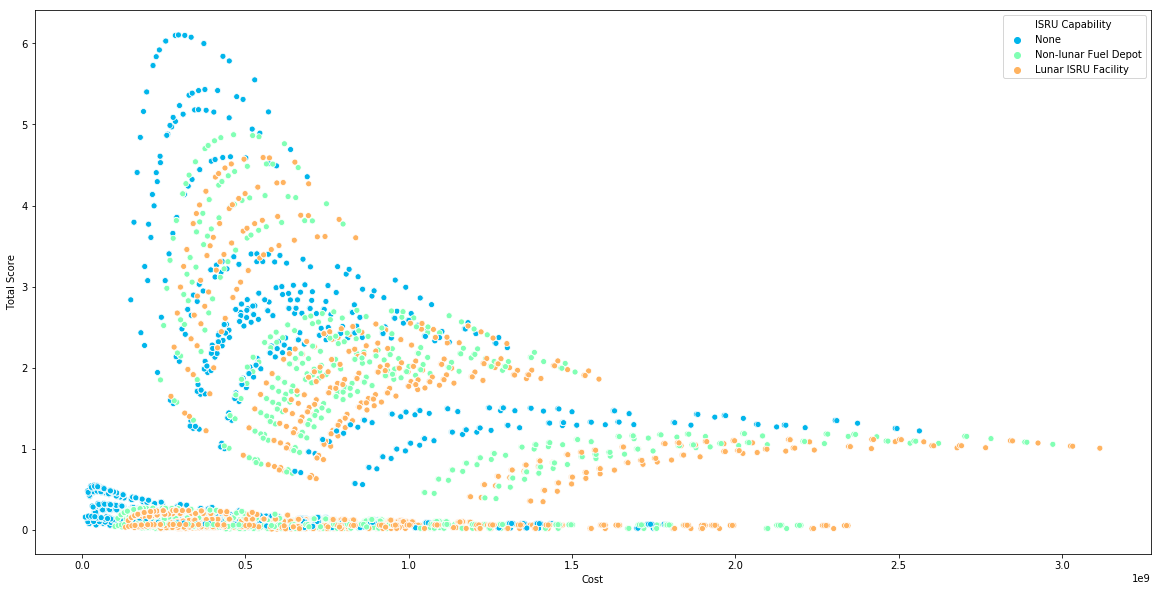

In [68]:
plt.figure(figsize = (20,10))
sns.scatterplot(business_case['Cost'],
                business_case['Total Score'],
                hue = business_case['ISRU Capability'],
                legend = "full",
                palette = 'rainbow')
plt.show()

## Let's look at the same plot as above, but vary the number of crew. This can show us how it impacts the dependent variables

In [39]:
# plt.figure(figsize = (20,10))
# sns.scatterplot(business_case['Cost'],
#                 business_case['Total Score'],
#                 hue = business_case['Number of Crew'],
#                 legend = "full",
#                 palette = 'flag')
# plt.show()

## Now let's see how exploration capability relates to IMLEO

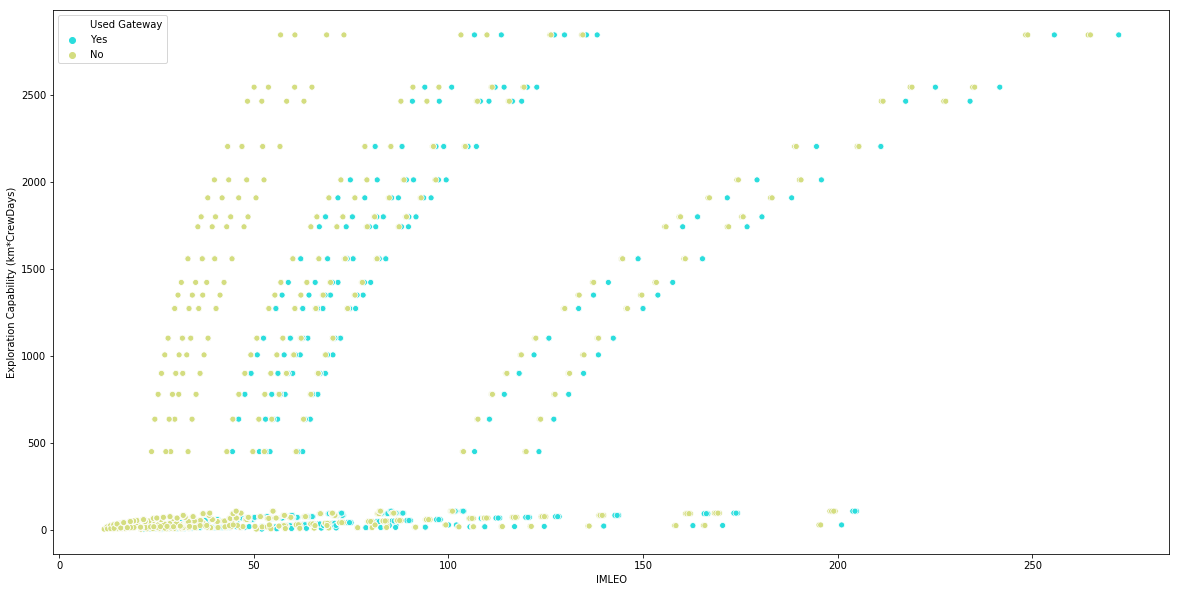

In [40]:
plt.figure(figsize = (20,10))
sns.scatterplot(business_case['IMLEO'],
                business_case['Exploration Capability (km*CrewDays)'],
                hue = business_case['Used Gateway'],
                legend = "full",
                palette = 'rainbow')
plt.show()

## Now let's look at commercial merit vs. cost

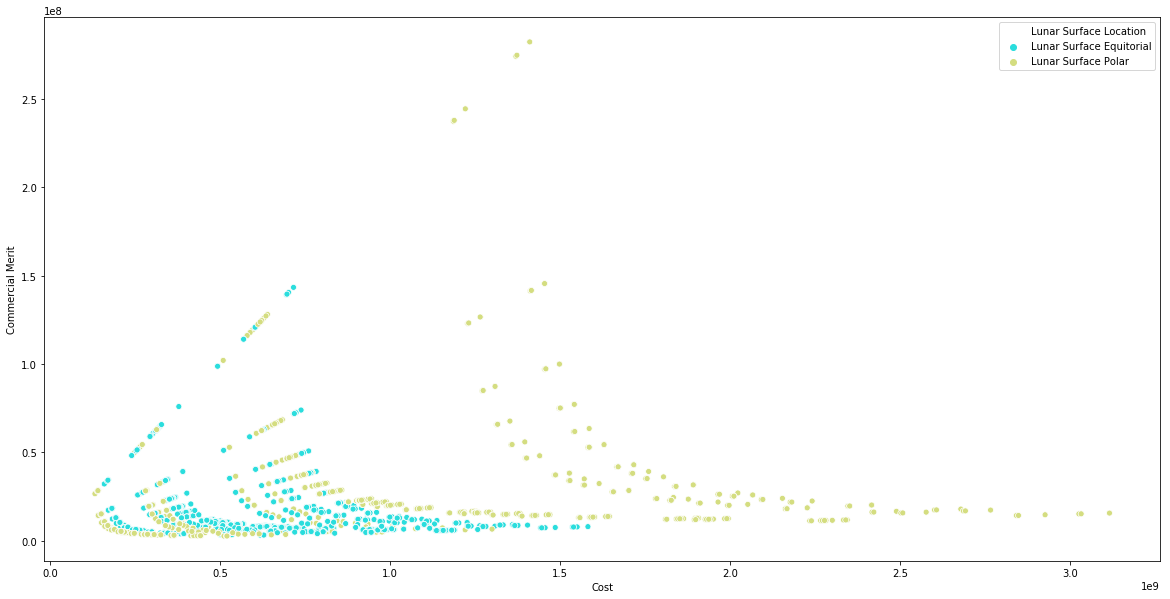

In [41]:
plt.figure(figsize = (20,10))
sns.scatterplot(business_case['Cost'],
                business_case['Commercial Merit'],
                hue = business_case['Lunar Surface Location'],
                legend = "full",
                palette = 'rainbow')
plt.show()

## Lastly let's look at commercial merit vs. exploration capability, so we can see our pareto frontier for a mission which would serve both NASA's and commercial needs

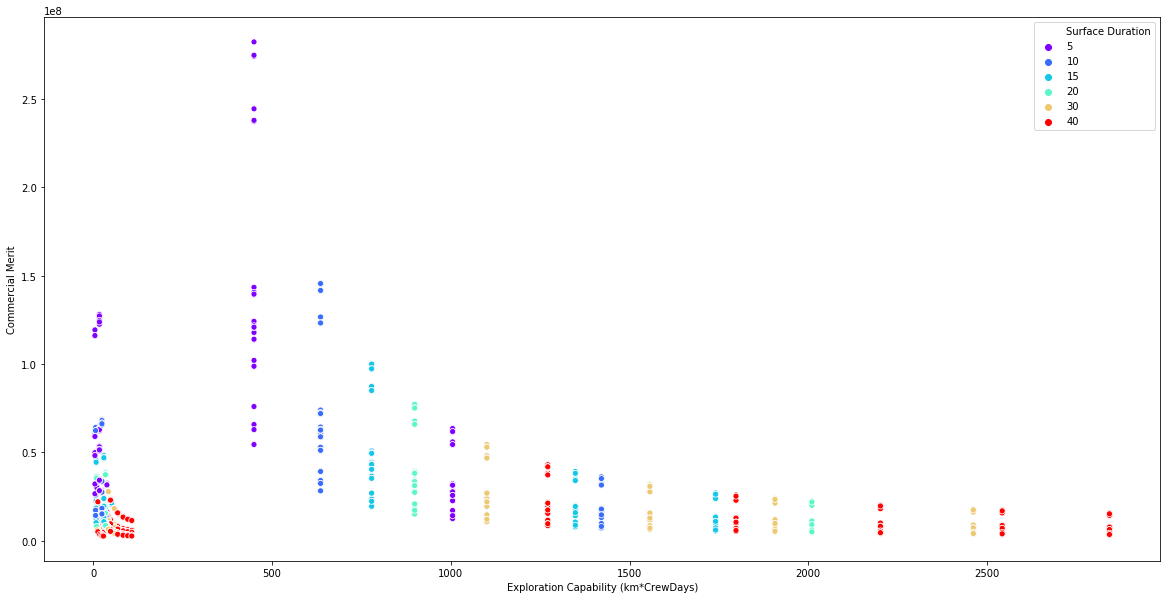

In [43]:
plt.figure(figsize = (20,10))
sns.scatterplot(business_case['Exploration Capability (km*CrewDays)'],
                business_case['Commercial Merit'],
                hue = business_case['Surface Duration'],
                legend = "full",
                palette = 'rainbow')
plt.show()

# Let us know take a look at some more intricate plots and data

## Facet Grid is used to help control certain parameters, while also enabling some nice dynamics

### Facet grid allows us to hold certain variables constant and then produce lots of pretty plots that depict all the good stuff



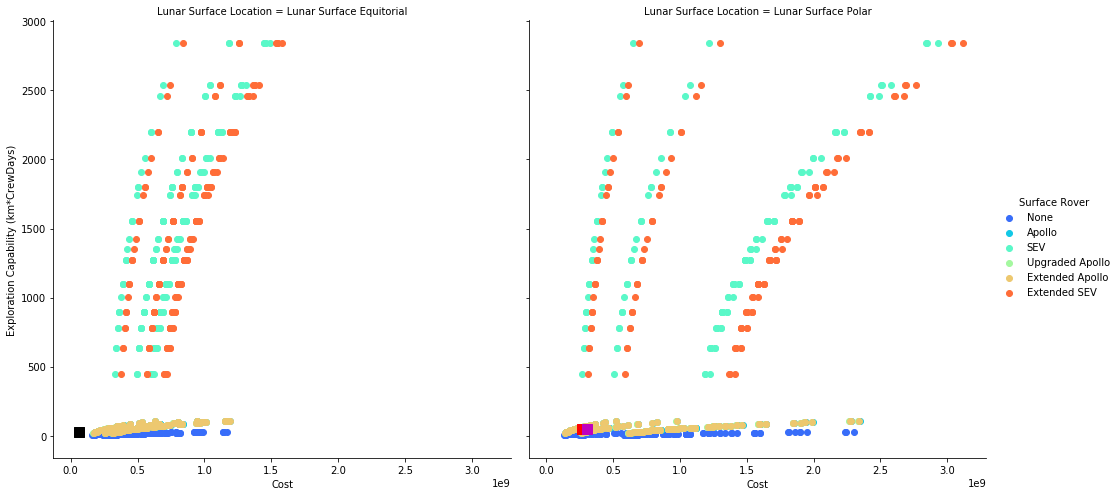

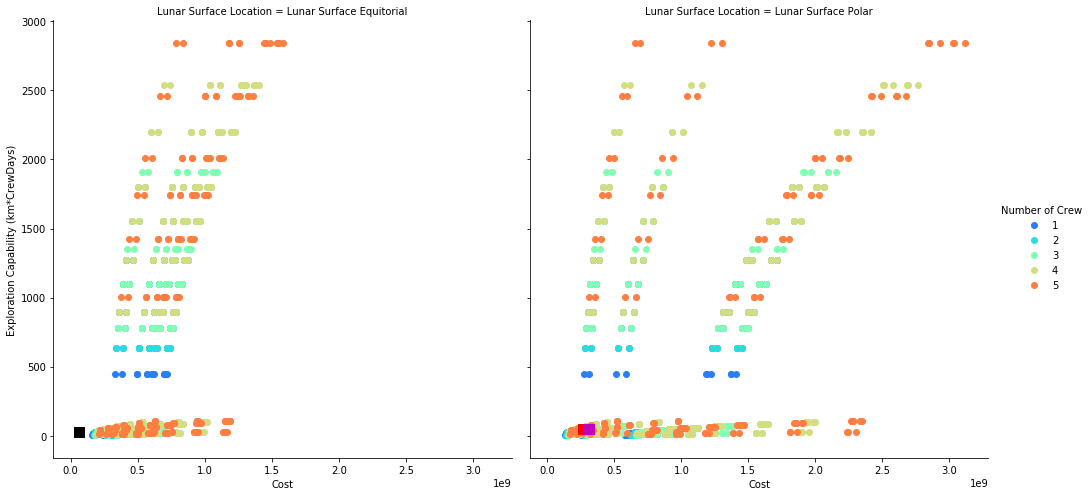

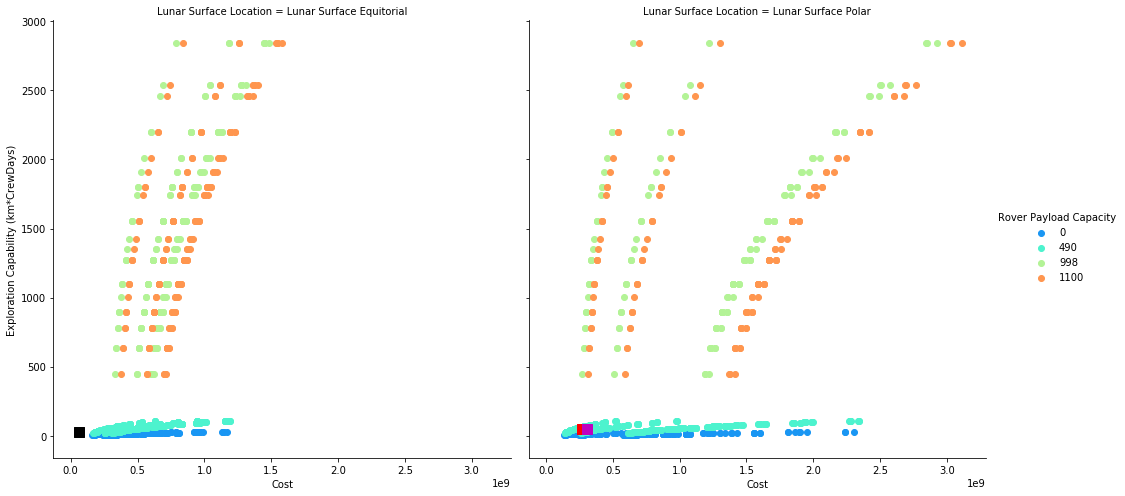

In [40]:
g = sns.FacetGrid(business_case,col = "Lunar Surface Location",hue = 'Surface Rover',height=7, palette="rainbow")
g = g.map(plt.scatter,"Cost","Exploration Capability (km*CrewDays)").add_legend()
axes = g.axes.flat
axes[0].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['Apollo 17'],x = reference_df['Cost']['Apollo 17'],c = 'k',s = 100, marker = 's')
axes[1].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['Constellation'],x = reference_df['Cost']['Constellation'],c = 'r',s = 100, marker = 's')
axes[1].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['NASA DRM'],x = reference_df['Cost']['NASA DRM'],c = 'm',s = 100, marker = 's')


h = sns.FacetGrid(business_case,col = "Lunar Surface Location",hue = 'Number of Crew',height=7, palette="rainbow")
h = h.map(plt.scatter,"Cost","Exploration Capability (km*CrewDays)").add_legend()
axes = h.axes.flat
axes[0].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['Apollo 17'],x = reference_df['Cost']['Apollo 17'],c = 'k',s = 100, marker = 's')
axes[1].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['Constellation'],x = reference_df['Cost']['Constellation'],c = 'r',s = 100, marker = 's')
axes[1].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['NASA DRM'],x = reference_df['Cost']['NASA DRM'],c = 'm',s = 100, marker = 's')

i = sns.FacetGrid(business_case,col = "Lunar Surface Location",hue = 'Rover Payload Capacity',height=7, palette="rainbow")
i = i.map(plt.scatter,"Cost","Exploration Capability (km*CrewDays)").add_legend()
axes = i.axes.flat
axes[0].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['Apollo 17'],x = reference_df['Cost']['Apollo 17'],c = 'k',s = 100, marker = 's')
axes[1].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['Constellation'],x = reference_df['Cost']['Constellation'],c = 'r',s = 100, marker = 's')
axes[1].scatter(y = reference_df['Exploration Capability (km*CrewDays)']['NASA DRM'],x = reference_df['Cost']['NASA DRM'],c = 'm',s = 100, marker = 's')

plt.show()

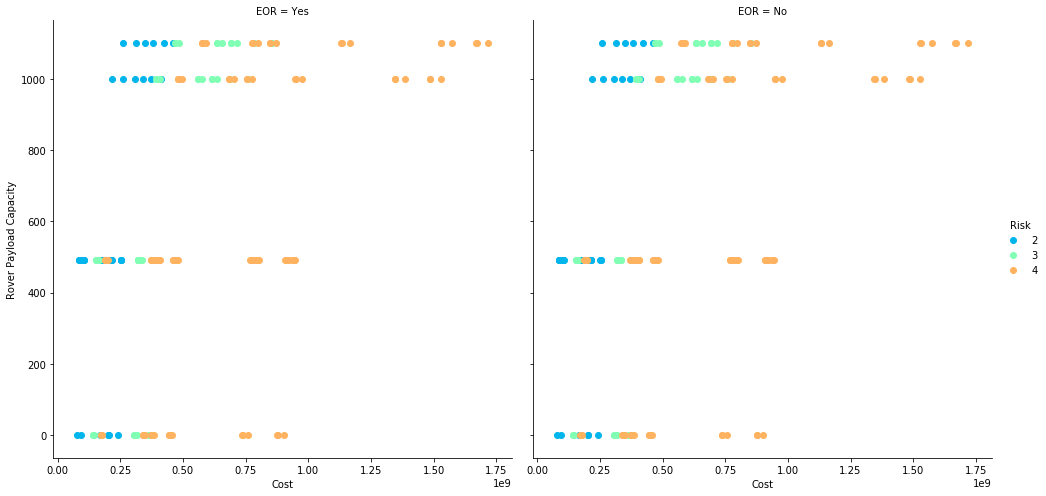

In [41]:
test = df_2[(df_2['Number of Crew'] == 4)
            & (df_2['Surface Duration'] == 10)
            & (df_2['First Stop From Earth'] == "LEO KSC")
                        ]
t = sns.FacetGrid(test,col = "EOR",hue = 'Risk',height=7, palette="rainbow")
t = t.map(plt.scatter,"Cost","Rover Payload Capacity").add_legend()
